**Data Engineer exercises**
- Date: 9/14/2020
- Purpose: ALS Data Engineer exercise




<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

## Auxiliary code to structure notebook

HTML code to left align markdown tables

In [1]:
%%html
<style>
table {float:left}
</style>

javacript code to update ToC

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Purpose
This notebook contains solutions to the Anne Lewis Strategies Hiring Data Engineer Exercise.

## Question 1
**Produce a “people” file with the following schema. Save it as a CSV with a header line to the working directory.**

    
| Column | Type | Description |
| :-- | :-- | :-- |
|email | string | Primary email address | 
|code | string | Source code |
|is_unsub | boolean | If primary email address is unsubscribed |
|created_dt | datetime | Person creation datetime |
| pdated_dt | datetime | Person updated datetime |



## Question 2
**Use the output of #1 to produce an “acquisition_facts” file with the following schema that aggregates stats about when people in the dataset were acquired. Save it to the working directory.**

| Column | Type | Description | 
| :-- | :-- | :-- |
| acquisition_date | date | Calendar date of acquisition | 
| acquisitions | int | Number of constituents acquired on acquisition date |

# Method Notes
This section contains a summary on the methodologies used in this notebook's data analysis

## Relational joins
The three data files are relational data that contain primary and foreign keys to connect information about users.

I use `df_emails` as the base data file because it contains the most user records.
Left joins to the df_emails table will be made such that all email addresses are preserved. My analysis assumes that email addresses are the variable of interest.

Given df_emails, the following left joins can be made:
- df_emails.cons_email_id = df_subs.cons_email_id
- df_emails.cons_id = df_info.cons_id

*NOTE*: Because I used a left_join, it's likely that there will be NULL values in merged columns.

## Handling missing data
In my data analysis, I err on the side of preserving data instead of deleting it. This is because it's much easier to delete data than merge it again from another data source. This is not the case for duplicate values that create validity issues.

I initially found missing data in the `source` column for Constituent Data. I transformed NULL values into 'unknown' for analysis.

After using a LEFT merge on the data (`df_emails`, `df_sub`), I found that there were NULL values in the `is_unsub` column from `df_subs`. Because question 2 does not utilize the `is_unsub` column, I transform the NULL values into `unknown`.

## Duplicate values

hello

# Libraries

In [3]:
import os
import re
from typing import List, Tuple, Union


import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns

## Uncomment below code to install non-standard 3rd party libraries
# missingno used to identify missing data
# pywrangle is an open-source library I am developing for data cleaning
# ! pip install missingno
# ! pip install pywrangle  


import missingno as msno
import pywrangle as pw

header = '#' * 10
print('\n', header, "# Loaded libraries", header, sep = '\n')



##########
# Loaded libraries
##########


# Import Data

The following 3 data sources are used:

1. [Constituent Information](https://als-hiring.s3.amazonaws.com/fake_data/2020-07-01_17%3A11%3A00/cons.csv)
2. [Constituent Email Addresses](https://als-hiring.s3.amazonaws.com/fake_data/2020-07-01_17%3A11%3A00/cons_email.csv)
3. [Constituent Subscription Status](https://als-hiring.s3.amazonaws.com/fake_data/2020-07-01_17%3A11%3A00/cons_email_chapter_subscription.csv)

*Note*: Boolean columns (including is_primary) in all of these datasets are 1/0 numeric values. 1 means True, 0 means False.

In [4]:
cons_data_csvs = (
    'cons.csv',                             ## Constitutient information
    'cons_email.csv',                       ## Constitutient emails
    'cons_email_chapter_subscription.csv'   ## Constitutient subscription status
)

def load_df(filename_csv: str) -> object:
    """Loads csv file into dataframe and prints confirmation"""
    df = pd.read_csv(filename_csv)
    print(f"""Loaded df for {filename_csv}:
    {len(df.columns)} columns
    {len(df)} rows""")
    return df

df_info, df_emails, df_subs = (load_df(file) for file in cons_data_csvs)

all_cons_dfs = (df_info, df_emails, df_subs)

Loaded df for cons.csv:
    29 columns
    700000 rows
Loaded df for cons_email.csv:
    16 columns
    1400000 rows
Loaded df for cons_email_chapter_subscription.csv:
    6 columns
    350000 rows


# Data cleaning

## Check data
This section looks at the head and schema of each dataframe, and then identifies relevant columns for the ETL exercise.

In [5]:
## Look at constituent information
df_info.head(5)

,cons_id,prefix,firstname,middlename,lastname,suffix,salutation,gender,birth_dt,title,...,change_password_next_login,consent_type_id,create_dt,create_app,create_user,modified_dt,modified_app,modified_user,status,note
0,1,NaN,NaN,Lee,NaN,MD,NaN,E,NaN,vSkSIzEQJdXnqeTTTXSG,...,0,5958,"Fri, 1983-08-26 06:02:03",1484,6162,"Sun, 2015-12-27 09:28:02",4022,6349,1,NaN
1,2,NaN,NaN,NaN,NaN,II,boFqBKgLlSgEZsFrgCZd,E,"Mon, 2004-11-15",NaN,...,1,4236,"Mon, 1979-03-05 21:08:54",4176,5476,"Tue, 1989-06-20 13:28:57",9010,5698,1,NaN
2,3,NaN,NaN,David,King,NaN,NaN,D,"Fri, 1994-04-08",bxGxufoNzpKvjwNIxgRj,...,1,1263,"Fri, 2008-08-22 19:20:28",4702,8239,"Fri, 2020-06-05 18:13:57",8837,1175,1,NaN
3,4,Ms.,Mark,Gregg,NaN,NaN,NaN,J,NaN,NaN,...,0,949,"Sun, 1984-04-29 11:18:18",7096,7875,"Tue, 2012-01-31 07:26:35",7529,3984,1,NaN
4,5,NaN,NaN,Logan,NaN,DDS,ArvPJuEozHPaqbirovMi,D,"Sun, 2008-08-10",kXKlKCyCBoXUBVejPOVO,...,0,7126,"Thu, 2007-07-19 18:28:09",706,5727,"Tue, 1971-04-27 06:53:53",9356,6062,1,NaN


In [6]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   cons_id                     700000 non-null  int64  
 1   prefix                      350304 non-null  object 
 2   firstname                   350244 non-null  object 
 3   middlename                  560213 non-null  object 
 4   lastname                    349314 non-null  object 
 5   suffix                      349541 non-null  object 
 6   salutation                  350021 non-null  object 
 7   gender                      349891 non-null  object 
 8   birth_dt                    349954 non-null  object 
 9   title                       350082 non-null  object 
 10  employer                    349228 non-null  object 
 11  occupation                  350239 non-null  object 
 12  income                      350637 non-null  float64
 13  source        

Relevant columns in **df_info**:
- `cons_id`: primary key, relates to other columns
- `source`: code string data for q1 table
- `create_dt`: created_dt datetime data for q1 table
- `modified_dt`: updated_dt datetime for q1 table

In [7]:
## Look at constituent emails
df_emails.head(5)

,cons_email_id,cons_id,cons_email_type_id,is_primary,email,canonical_local_part,domain,double_validation,create_dt,create_app,create_user,modified_dt,modified_app,modified_user,status,note
0,1,548198,3361,1,xmartinez@vincent.com,NaN,gmail.com,NaN,"Wed, 1994-01-26 23:49:16",4072,9954,"Sat, 2014-04-19 19:10:39",1990,7595,1,NaN
1,2,491137,2474,1,hmiller@haynes.biz,jqCyozTDojYuylQPTHfm,hotmail.com,NaN,"Thu, 1999-12-09 06:18:27",1600,5716,"Sat, 1984-07-14 05:55:27",4686,3248,1,NaN
2,3,413429,5175,1,aaron64@yahoo.com,FCBeBiVoqnnKDWjnllhN,yahoo.com,kRLZexQEwYIMbwFNvQxg,"Wed, 1992-11-18 16:46:27",7358,2685,"Sun, 1995-12-24 13:13:01",3857,7405,1,NaN
3,4,347346,4117,1,wyattvincent@hotmail.com,NaN,gmail.com,zSbfmlqXimGyWVBUGdQg,"Sat, 1983-11-26 16:49:14",881,3444,"Sun, 1975-01-19 14:32:56",8713,7713,1,NaN
4,5,443000,6781,1,tspencer@hotmail.com,VaQIYlKcUkIywkKKEptD,gmail.com,NaN,"Wed, 2000-11-15 13:28:34",5380,5456,"Sun, 1994-03-13 16:38:37",765,8618,1,NaN


In [8]:
df_emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 16 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   cons_email_id         1400000 non-null  int64 
 1   cons_id               1400000 non-null  int64 
 2   cons_email_type_id    1400000 non-null  int64 
 3   is_primary            1400000 non-null  int64 
 4   email                 1400000 non-null  object
 5   canonical_local_part  700029 non-null   object
 6   domain                1400000 non-null  object
 7   double_validation     699825 non-null   object
 8   create_dt             1400000 non-null  object
 9   create_app            1400000 non-null  int64 
 10  create_user           1400000 non-null  int64 
 11  modified_dt           1400000 non-null  object
 12  modified_app          1400000 non-null  int64 
 13  modified_user         1400000 non-null  int64 
 14  status                1400000 non-null  int64 
 15

Relevant columns in **df_emails**:
- `cons_email_id`: primary key
- `cons_id`: foreign key used to link to df_info
- `email`: email string data for q1 table

*NOTE:*
There are two unclear elements in this table.
- `create_dt`: unclear if this may also fulfill q1 table requirement.
- `modified_dt`: unclear if this may also fulfill q1 table requirement

However, because these are associated in the email information, I will assume that the `create_dt` and `modified_dt` is used for the email, and not the person. As such, I will use the `create_dt` and `modified_dt` in df_info.

In [9]:
## Look at constituent subscription status
df_subs.head(5)

,cons_email_chapter_subscription_id,cons_email_id,chapter_id,isunsub,unsub_dt,modified_dt
0,1,332188,1,1,"Sat, 1971-06-12 15:38:44","Thu, 1990-06-28 10:54:20"
1,2,536526,1,1,"Wed, 2006-07-12 01:50:45","Thu, 1979-09-20 06:02:35"
2,3,134711,1,1,"Tue, 1987-01-06 13:05:15","Sun, 1974-03-03 15:11:50"
3,4,660345,1,1,"Sat, 2016-08-06 11:06:09","Wed, 1995-09-13 23:45:03"
4,5,184268,1,1,"Sun, 2000-05-28 02:20:45","Sat, 1983-12-10 08:09:58"


In [10]:
df_subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350000 entries, 0 to 349999
Data columns (total 6 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   cons_email_chapter_subscription_id  350000 non-null  int64 
 1   cons_email_id                       350000 non-null  int64 
 2   chapter_id                          350000 non-null  int64 
 3   isunsub                             350000 non-null  int64 
 4   unsub_dt                            350000 non-null  object
 5   modified_dt                         350000 non-null  object
dtypes: int64(4), object(2)
memory usage: 16.0+ MB


Relevant columns in **df_subs**:
- `cons_email_chapter_subscription_id`: primary key
- `cons_email_id`: foreign key to link to df_emails
- `isunsub`: is_unsub boolean data for q1 table

## Identify entity relationships
The three data files are relational data that contain primary and foreign keys to connect information about users.

I use `df_emails` as the base data file because it contains the most user records.
Left joins to the df_emails table will be made such that all email addresses are preserved.

Given df_emails, the following joins can be made:
- df_emails.cons_email_id = df_subs.cons_email_id
- df_emails.cons_id = df_info.cons_id

*Note*: At this point, relationships appear to be one-to-one.


## Keep relevant columns
To increase notebook performance and readability, I only keep columns that are relevant to the analysis.

Based on the questions outlined in this exercise and the columns identified in [Check Data](#check-data), I am interested in the following columns for each dataframe:

**df_info:**
- `cons_id`: primary key, relates to other columns
- `source`: code string data for q1 table
- `create_dt`: created_dt datetime data for q1 table
- `modified_dt`: updated_dt datetime for q1 table

**df_emails:**
- `cons_email_id`: primary key
- `cons_id`: foreign key used to link to df_info
- `email`: email string data for q1 table

**df_subs:**
- `cons_email_chapter_subscription_id`: primary key
- `cons_email_id`: foreign key to link to df_emails
- `isunsub`: is_unsub boolean data for q1 table

In [11]:
## columns to save for each df
cols_df_info = [
    'cons_id',
    'source',
    'create_dt',
    'modified_dt'
]
cols_df_email = [
    'cons_email_id',
    'cons_id',
    'email',
#     'create_dt',
#     'modified_dt',
]
cols_df_subs = [
    'cons_email_chapter_subscription_id',
    'cons_email_id',
    'isunsub'
]


In [12]:
## Auxilary function to modify df and track changes
def keep_df_cols(df: object, columns: list) -> object:
    """Returns pandas dataframe with only specified columns.
    
    Uses pywrangle to document df changes."""
    df_old = pw.record_df_info(df)
    df = df[columns]
    pw.print_df_changes(df, df_old)
    return df


In [13]:
## Keep information columns
df_info = keep_df_cols(df_info, cols_df_info)
df_info.head()

df       	num rows  	num columns  	df.size    	
--       	--------  	-----------  	-------    	
before   	700000    	29           	20300000   	
after    	700000    	4            	2800000    	
df diff  	0         	-25          	-17500000  	
% diff   	0.0%      	-86.21%      	-86.21%    	



,cons_id,source,create_dt,modified_dt
0,1,google,"Fri, 1983-08-26 06:02:03","Sun, 2015-12-27 09:28:02"
1,2,facebook,"Mon, 1979-03-05 21:08:54","Tue, 1989-06-20 13:28:57"
2,3,NaN,"Fri, 2008-08-22 19:20:28","Fri, 2020-06-05 18:13:57"
3,4,google,"Sun, 1984-04-29 11:18:18","Tue, 2012-01-31 07:26:35"
4,5,NaN,"Thu, 2007-07-19 18:28:09","Tue, 1971-04-27 06:53:53"


Drop 25 columns from `df_info` and 86% of the data.

In [14]:
## Keep email columns
df_emails = keep_df_cols(df_emails, cols_df_email)
df_emails.head()

df       	num rows  	num columns  	df.size    	
--       	--------  	-----------  	-------    	
before   	1400000   	16           	22400000   	
after    	1400000   	3            	4200000    	
df diff  	0         	-13          	-18200000  	
% diff   	0.0%      	-81.25%      	-81.25%    	



,cons_email_id,cons_id,email
0,1,548198,xmartinez@vincent.com
1,2,491137,hmiller@haynes.biz
2,3,413429,aaron64@yahoo.com
3,4,347346,wyattvincent@hotmail.com
4,5,443000,tspencer@hotmail.com


Drop 13 columns from `df_emails` and 81% of the data.

In [15]:
## Keep subscription columns
df_subs = keep_df_cols(df_subs, cols_df_subs)
df_subs.head()

df       	num rows  	num columns  	df.size   	
--       	--------  	-----------  	-------   	
before   	350000    	6            	2100000   	
after    	350000    	3            	1050000   	
df diff  	0         	-3           	-1050000  	
% diff   	0.0%      	-50.0%       	-50.0%    	



,cons_email_chapter_subscription_id,cons_email_id,isunsub
0,1,332188,1
1,2,536526,1
2,3,134711,1
3,4,660345,1
4,5,184268,1


Drop 3 columns from `df_subs` and 50% of the data.

## Missing data
Look at the missing data in each dataframe.

In [16]:
def check_df_missing_data(df: object, df_name: str) -> None:
    """Creates msno.bar graph of data present in dataframe."""
    msno.bar(df)
    plt.title(f"Non-NULL values for {df_name} data.")
    plt.xlabel("Column")
    plt.ylabel("% data present")
    plt.figure(figsize=(5, 2))

### missing constituent info data

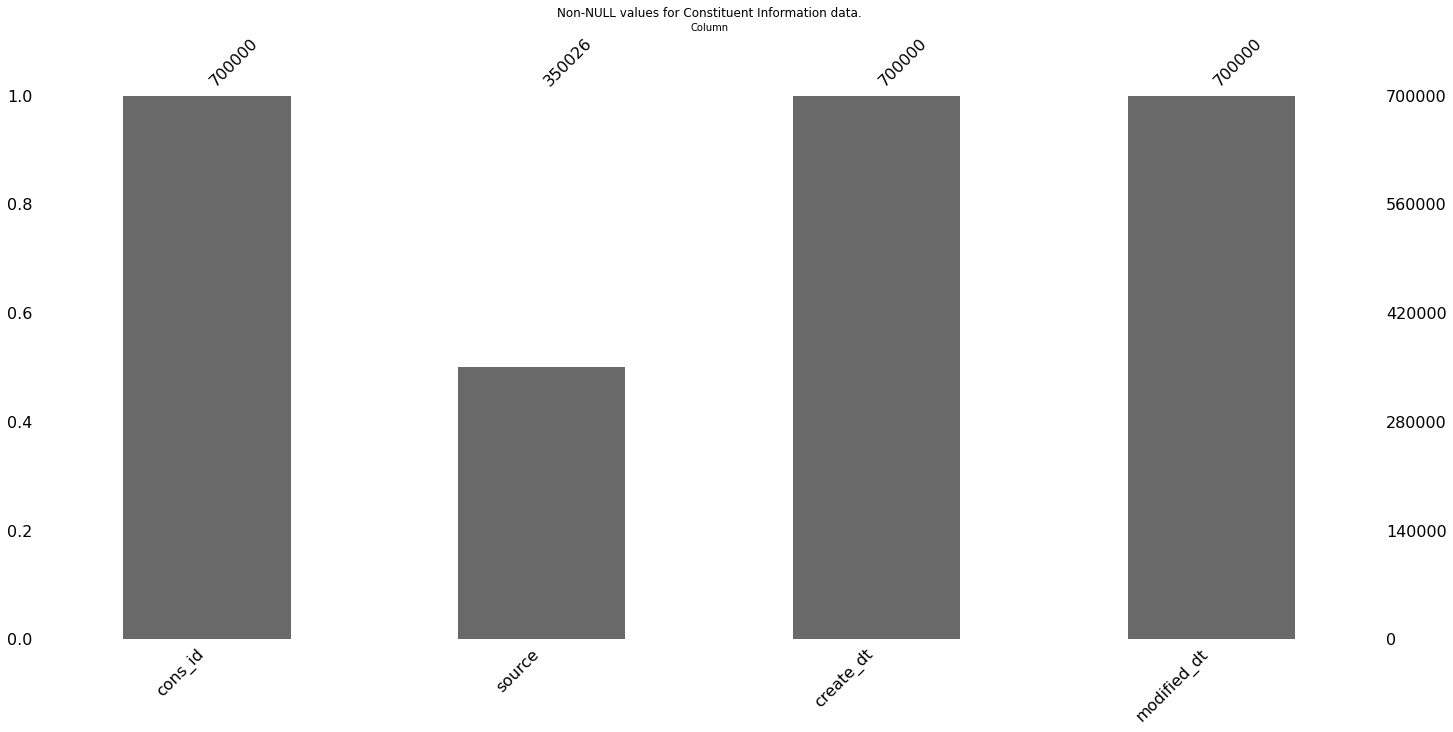

<Figure size 360x144 with 0 Axes>

In [17]:
check_df_missing_data(df_info, "Constituent Information")

NOTE: There `source` column is missing approximately half of its data. Because there is still relevant information on for `create_dt` and `modified_dt`, I will keep missing data in the source columns,

In [18]:
df_info['source'].value_counts()

organic     87875
google      87614
twitter     87510
facebook    87027
Name: source, dtype: int64

Source data is categorical with 4 categories:
- organic
- google
- twitter
- facebook

Because about half of source values are NULL, I will preserve them and label them as `unknown`.

In [19]:
df_info['source'].fillna("unknown", inplace = True)

C:\Users\Jai\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Check NULLs are transformed

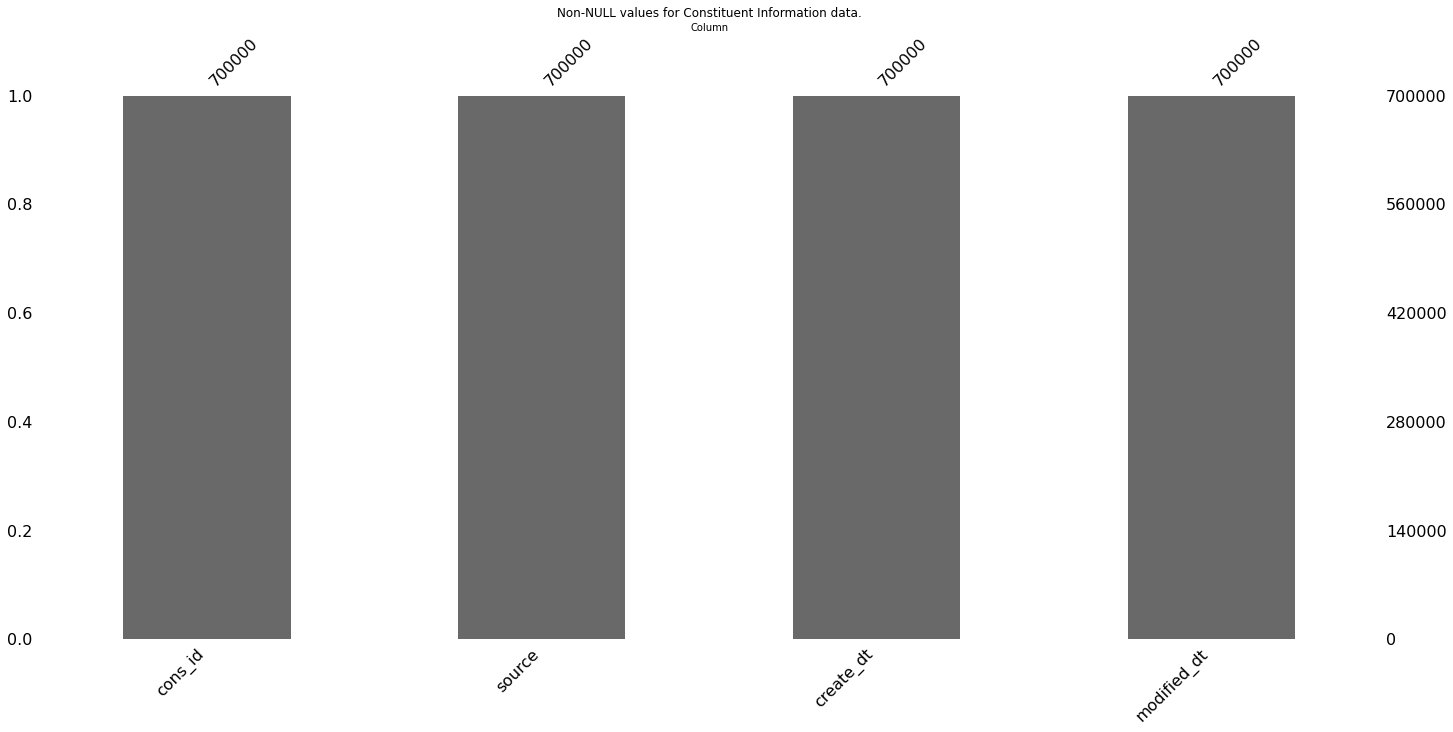

<Figure size 360x144 with 0 Axes>

In [20]:
check_df_missing_data(df_info, "Constituent Information")

In [21]:
df_info['source'].value_counts()

unknown     349974
organic      87875
google       87614
twitter      87510
facebook     87027
Name: source, dtype: int64

### missing email data

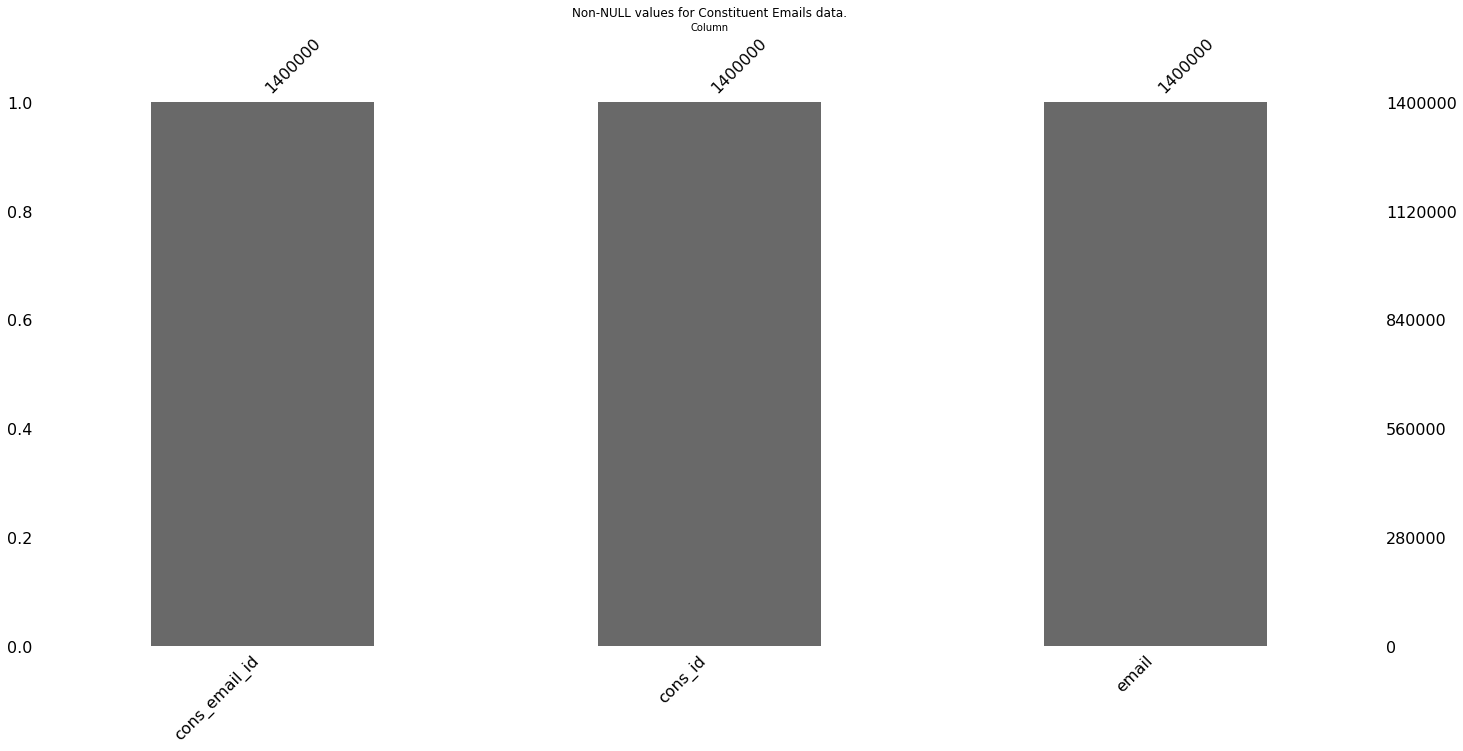

<Figure size 360x144 with 0 Axes>

In [22]:
check_df_missing_data(df_emails, "Constituent Emails")

No missing values in `df_emailss`

### missing subscription data

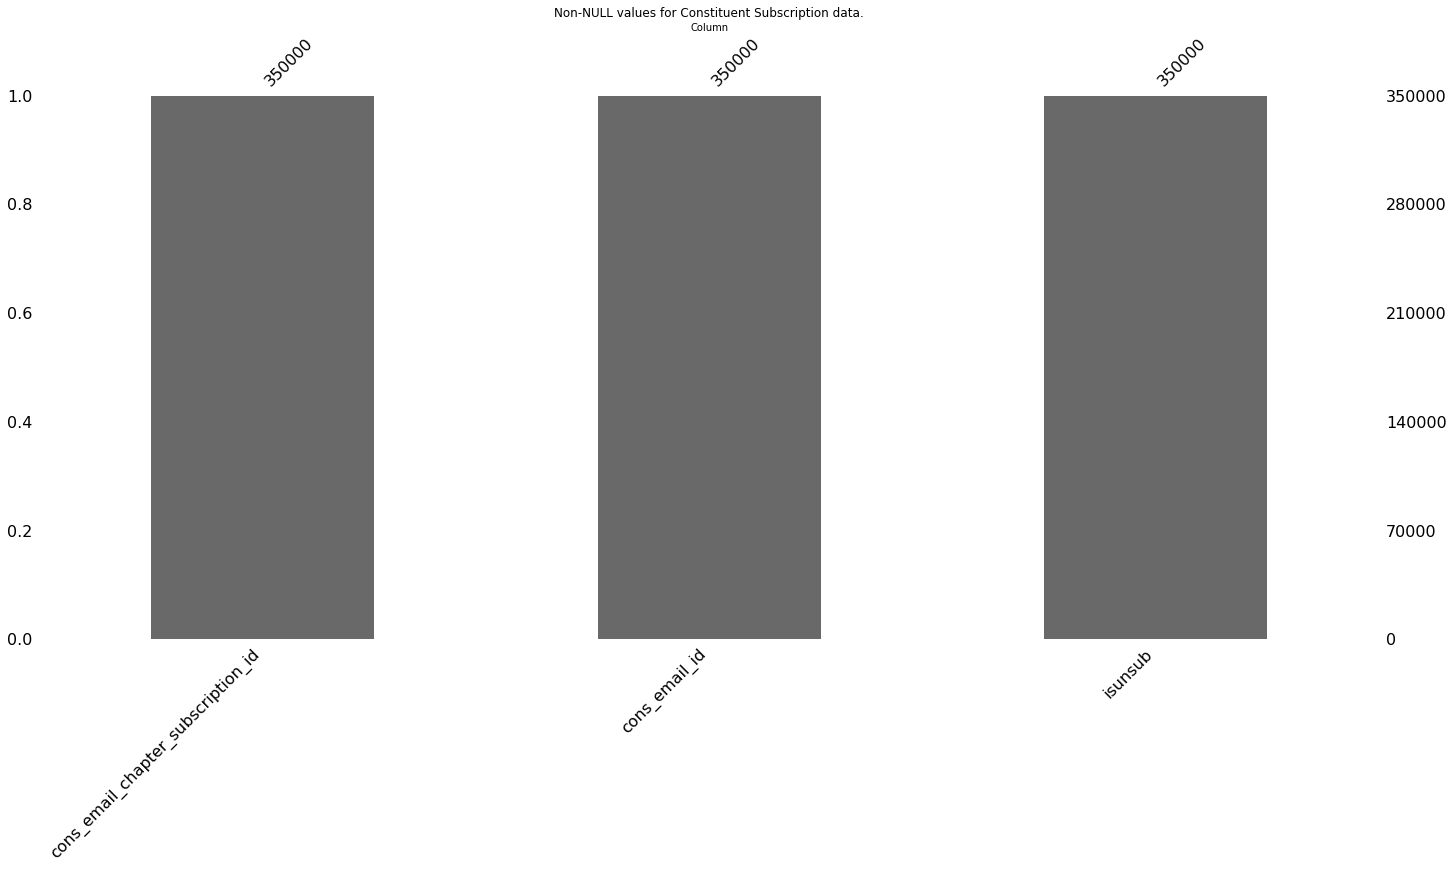

<Figure size 360x144 with 0 Axes>

In [23]:
check_df_missing_data(df_subs, "Constituent Subscription")

No missing values in `df_subs`.

## Clean string data
This section cleans string data in the data frame columns.

All strings are lower cased in the column for consistency purposes.

### standardize constituent information
Use pywrangle to standardize string column casing. Past tuple of tuples containing the column to clean, and an integer representing the cleaning method to use.

In [24]:
cons_info_strcol_caseint: Tuple[Tuple[ str, int]] = (
    ("source", 0),
    ("create_dt", 0),
    ("modified_dt", 0)
)
df_info = pw.clean_str_columns( df_info, cons_info_strcol_caseint)

Column		Str Cleaning
------		------------


C:\Users\Jai\anaconda3\lib\site-packages\pywrangle\string_cleaning.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df.loc[:, col_name].str.strip()
C:\Users\Jai\anaconda3\lib\site-packages\pywrangle\string_cleaning.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df.loc[:, col_name].str.lower()


source 		lower
create_dt		lower
modified_dt		lower



### standardize emails

In [25]:
cons_email_strcol_caseint: Tuple[Tuple[ str, int]] = (
    ('email', 0),
)
df_emails = pw.clean_str_columns( df_emails, cons_email_strcol_caseint)

Column		Str Cleaning
------		------------
email  		lower



### standardize subscription information

No string data in `df_subs`

## Check duplicates
This section checks for duplicate data entries in the different dataframes

In [26]:
## Auxiliary function to check duplicates
def check_df_duplicates(df, check_columns: List[str]) -> None:
    """Prints df and df.size of duplicates rows, and duplicates for specified columns."""
    ## duplicate rows
    df_duplicate_rows = df[df.duplicated() == True]
    print(f"Number of df duplicate rows {len(df_duplicate_rows)}")
    
    ## duplicates in column
    for col in check_columns:
        df_col_duplicates = df[df.duplicated(col)]
        print(f"Number of duplicates in {col}: {len(df_col_duplicates)}")
    return None

In [27]:
## Auxiliary function to remove duplicates
def remove_df_duplicates(df, column: str, keep: Union[str, bool] = False) -> "dataframe":
    """Auxiliary method to remove rows with duplicates n specified column.
    
    Uses pywrangle to record difference in df."""
    old_df = pw.record_df_info(df)
    df.drop_duplicates(subset = column, keep = keep, inplace = True)
    pw.print_df_changes(df, old_df)
    return df
    

### info duplicates

In [28]:
print(df_info.columns)

Index(['cons_id', 'source', 'create_dt', 'modified_dt'], dtype='object')


In [29]:
check_cols = ['cons_id']
check_df_duplicates(df_info, check_columns = check_cols)

Number of df duplicate rows 0
Number of duplicates in cons_id: 0


### email duplicates

In [30]:
print(df_emails.columns)

Index(['cons_email_id', 'cons_id', 'email'], dtype='object')


In [31]:
check_cols = ['cons_email_id', 'cons_id']
check_df_duplicates(df_emails, check_columns = check_cols)

Number of df duplicate rows 0
Number of duplicates in cons_email_id: 0
Number of duplicates in cons_id: 794361


In [32]:
dup_col = 'cons_id'
df_dup_emails = df_emails[df_emails.duplicated(dup_col, keep = False)].sort_values(dup_col)
df_dup_emails.head()

,cons_email_id,cons_id,email
560548,560549,1,misty66@walsh-hampton.biz
546911,546912,1,daniel72@hudson.com
1244041,1244042,1,lucassmith@yahoo.com
701584,701585,2,asmith@henderson-hill.com
415586,415587,2,caustin@spears-carson.com


There are a number of duplicate foreign keys for cons_id and we cannot be sure which user should reference the cons_id.

There *is* a small chance that `df_emails.cons_id` to `df_info.cons_id` is a one to many relationship. However, I find this highly improbable given `df_info` contains columns for name information.

For this notebook analysis, I opted to drop records with duplicate `cons_ids`

In [33]:
df_emails = remove_df_duplicates(df_emails, dup_col, keep = False)

df       	num rows             	num columns  	df.size              	
--       	--------             	-----------  	-------              	
before   	1400000              	3            	4200000              	
after    	189517               	3            	568551               	
df diff  	-1210483             	0            	-3631449             	
% diff   	-86.46000000000001%  	0.0%         	-86.46000000000001%  	



<ipython-input-27-9cbcb1e07c60>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset = column, keep = keep, inplace = True)


In [34]:
## Sanity check that the number of removed rows from df_emails == len(df_dup_emails)
len(df_dup_emails)

1210483

### subscription duplicates

In [35]:
print(df_subs.columns)

Index(['cons_email_chapter_subscription_id', 'cons_email_id', 'isunsub'], dtype='object')


In [36]:
check_cols = ['cons_email_chapter_subscription_id', 'cons_email_id']
check_df_duplicates(df_subs, check_columns = check_cols)

Number of df duplicate rows 0
Number of duplicates in cons_email_chapter_subscription_id: 0
Number of duplicates in cons_email_id: 74516


In [37]:
dup_col = 'cons_email_id'
df_dup_subs = df_subs[ df_subs.duplicated(dup_col, keep = False)].sort_values(dup_col)
df_dup_subs.head()

,cons_email_chapter_subscription_id,cons_email_id,isunsub
235123,235124,22,1
306251,306252,22,1
293877,293878,27,1
89885,89886,27,1
172076,172077,31,1


There are duplicate cons_email_ids. This means that 

*NOTE*: Further analysis may like to check if the variable of interest, `isunsub`, is the same for `cons_email_id`. If the variables are equivalent, may combine the rows and re-assign the primary key, `cons_email_chapter_subscription_id`.

For this analysis, I remove the rows with duplicate cons_email_ids

In [38]:
df_subs = remove_df_duplicates(df_subs, dup_col, keep = False)

df       	num rows              	num columns  	df.size               	
--       	--------              	-----------  	-------               	
before   	350000                	3            	1050000               	
after    	212488                	3            	637464                	
df diff  	-137512               	0            	-412536               	
% diff   	-39.290000000000006%  	0.0%         	-39.290000000000006%  	



<ipython-input-27-9cbcb1e07c60>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset = column, keep = keep, inplace = True)


In [39]:
## Sanity check that the rows from `df_subs` == `len(df_dup_subs)`
len(df_dup_subs)

137512

### Clean datettime
datetime data stored in df_info is stored in the {day, datetime} format. 
I want to convert this into ISO-datetime format for convenience.

In [40]:
df_info.head()

,cons_id,source,create_dt,modified_dt
0,1,google,"fri, 1983-08-26 06:02:03","sun, 2015-12-27 09:28:02"
1,2,facebook,"mon, 1979-03-05 21:08:54","tue, 1989-06-20 13:28:57"
2,3,unknown,"fri, 2008-08-22 19:20:28","fri, 2020-06-05 18:13:57"
3,4,google,"sun, 1984-04-29 11:18:18","tue, 2012-01-31 07:26:35"
4,5,unknown,"thu, 2007-07-19 18:28:09","tue, 1971-04-27 06:53:53"


In [41]:
## Auxiliary function to get datetime from day, datetime information stored in
def get_datetime(day_datetime: str) -> 'datetime':
    """Returns datetime object from str datetime.
    
    >>> get_datetime('sat, 2017-09-30 08:26:54') 
    2017-09-30 08:26:54
    """
    int_index = re.search(r'\d', day_datetime).start()
    datetime_list = list(day_datetime)[int_index:]
    return ''.join(datetime_list)

In [42]:
## Specify date-time format parser
datetime_format = "%Y-%m-%d %H:%M:%S"

## Cols to iterate through
datetime_cols = ('create_dt', 'modified_dt')

for col in datetime_cols:
    df_info[col] = df_info[col].map(get_datetime)
    df_info[col] = pd.to_datetime(df_info[col], format = datetime_format)
    

<ipython-input-42-73e096aa4df6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_info[col] = df_info[col].map(get_datetime)
<ipython-input-42-73e096aa4df6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_info[col] = pd.to_datetime(df_info[col], format = datetime_format)


In [43]:
df_info.head()

,cons_id,source,create_dt,modified_dt
0,1,google,1983-08-26 06:02:03,2015-12-27 09:28:02
1,2,facebook,1979-03-05 21:08:54,1989-06-20 13:28:57
2,3,unknown,2008-08-22 19:20:28,2020-06-05 18:13:57
3,4,google,1984-04-29 11:18:18,2012-01-31 07:26:35
4,5,unknown,2007-07-19 18:28:09,1971-04-27 06:53:53


In [44]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   cons_id      700000 non-null  int64         
 1   source       700000 non-null  object        
 2   create_dt    700000 non-null  datetime64[ns]
 3   modified_dt  700000 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 21.4+ MB


`create_dt` and `modified_dt` are now registered as datetime64 objects.

# Join data
In this section, I join the three dataframes into a single dataframe with the desired information for quesiton 1:
- email
- code
- is_unsub
- created_dt
- updated_dt

Given df_emails, the following left joins are made:
- df_emails.cons_email_id = df_subs.cons_email_id
- df_emails.cons_id = df_info.cons_id

In [45]:
## Left Join df_emails and df_info
df_email_info = pd.merge(left = df_emails, right = df_info, how= 'left', left_on = 'cons_id', right_on = 'cons_id')
df_email_info.head()

,cons_email_id,cons_id,email,source,create_dt,modified_dt
0,2,491137,hmiller@haynes.biz,google,2014-03-27 23:18:18,2012-12-10 18:46:32
1,4,347346,wyattvincent@hotmail.com,unknown,1993-05-23 08:00:18,1983-05-07 09:29:18
2,5,443000,tspencer@hotmail.com,twitter,1986-10-31 03:24:05,1979-09-22 05:01:01
3,24,267567,emorgan@smith.com,twitter,2005-06-30 14:00:15,1987-08-04 02:44:20
4,41,196127,vazquezamanda@yahoo.com,organic,1996-03-01 01:11:54,1978-04-25 22:58:38


In [46]:
## Create total data_frame for q1
df_email_info_subs = pd.merge(
    left = df_email_info, right = df_subs, 
    how = 'left', 
    left_on = 'cons_email_id', right_on = 'cons_email_id')
df_email_info_subs.sort_values(by = 'cons_id', inplace = True)
df_email_info_subs.head()

,cons_email_id,cons_id,email,source,create_dt,modified_dt,cons_email_chapter_subscription_id,isunsub
46238,339289,7,perrymatthew@campbell.com,unknown,1979-03-01 16:12:55,2019-03-13 02:52:10,NaN,NaN
189265,1398350,10,gillderrick@melton.net,twitter,1987-02-17 11:22:04,2016-03-19 17:33:38,NaN,NaN
179349,1324937,11,tomnelson@gmail.com,google,2018-04-19 10:44:52,1993-06-25 22:34:12,NaN,NaN
97094,715924,20,karenmcdaniel@hotmail.com,google,2011-03-21 17:41:32,1981-12-05 01:33:43,NaN,NaN
73693,542846,23,christy72@yahoo.com,facebook,1984-03-29 19:14:34,1993-12-17 12:10:30,NaN,NaN


In [47]:
df_email_info_subs.head()

,cons_email_id,cons_id,email,source,create_dt,modified_dt,cons_email_chapter_subscription_id,isunsub
46238,339289,7,perrymatthew@campbell.com,unknown,1979-03-01 16:12:55,2019-03-13 02:52:10,NaN,NaN
189265,1398350,10,gillderrick@melton.net,twitter,1987-02-17 11:22:04,2016-03-19 17:33:38,NaN,NaN
179349,1324937,11,tomnelson@gmail.com,google,2018-04-19 10:44:52,1993-06-25 22:34:12,NaN,NaN
97094,715924,20,karenmcdaniel@hotmail.com,google,2011-03-21 17:41:32,1981-12-05 01:33:43,NaN,NaN
73693,542846,23,christy72@yahoo.com,facebook,1984-03-29 19:14:34,1993-12-17 12:10:30,NaN,NaN


# Q1: 'People' File
This section saves the 'people' file as a csv with a header line.

In [48]:
desired_columns = [
    'email',
    'source',
    'isunsub',
    'create_dt',
    'modified_dt'
]
df_q1 = df_email_info_subs[desired_columns]
df_q1.reset_index(drop = True, inplace = True)
df_q1.head()

,email,source,isunsub,create_dt,modified_dt
0,perrymatthew@campbell.com,unknown,NaN,1979-03-01 16:12:55,2019-03-13 02:52:10
1,gillderrick@melton.net,twitter,NaN,1987-02-17 11:22:04,2016-03-19 17:33:38
2,tomnelson@gmail.com,google,NaN,2018-04-19 10:44:52,1993-06-25 22:34:12
3,karenmcdaniel@hotmail.com,google,NaN,2011-03-21 17:41:32,1981-12-05 01:33:43
4,christy72@yahoo.com,facebook,NaN,1984-03-29 19:14:34,1993-12-17 12:10:30


In [49]:
## Rename columns
q1_col_names = (
    'email',
    'code',
    'in_unsub',
    'created_dt',
    'updated_dt'
)
df_q1.columns = q1_col_names
df_q1.head()

,email,code,in_unsub,created_dt,updated_dt
0,perrymatthew@campbell.com,unknown,NaN,1979-03-01 16:12:55,2019-03-13 02:52:10
1,gillderrick@melton.net,twitter,NaN,1987-02-17 11:22:04,2016-03-19 17:33:38
2,tomnelson@gmail.com,google,NaN,2018-04-19 10:44:52,1993-06-25 22:34:12
3,karenmcdaniel@hotmail.com,google,NaN,2011-03-21 17:41:32,1981-12-05 01:33:43
4,christy72@yahoo.com,facebook,NaN,1984-03-29 19:14:34,1993-12-17 12:10:30


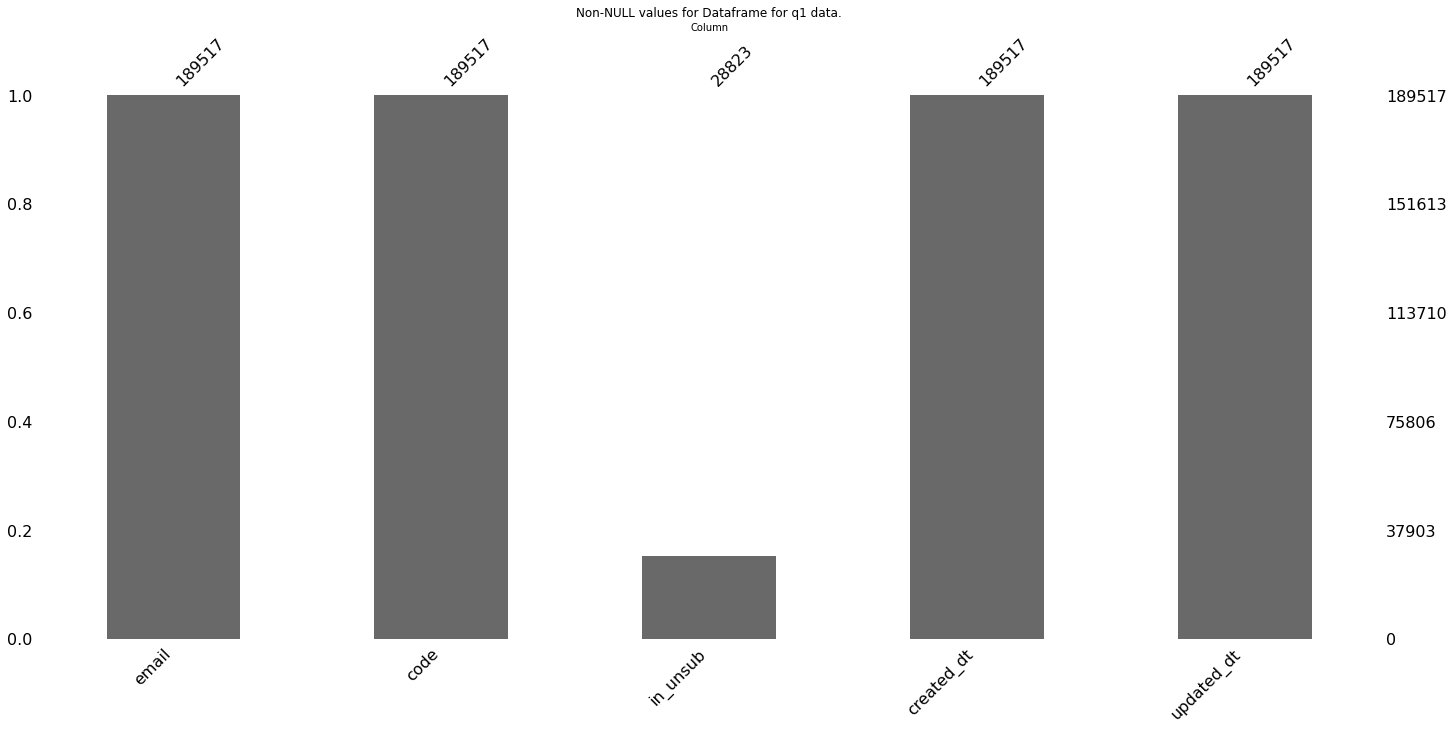

<Figure size 360x144 with 0 Axes>

In [50]:
check_df_missing_data(df_q1, "Dataframe for q1")

Note: The left join on emails to subcription status left many NULL values in the `in_unsub` column.

Because the second question does not specify to remove people who are unsubbed, I will preserve rows with NULL values in the `in_unsub` column. I will mark these values as `unknown`.

In [51]:
df_q1['in_unsub'].fillna('unknown', inplace = True)

C:\Users\Jai\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


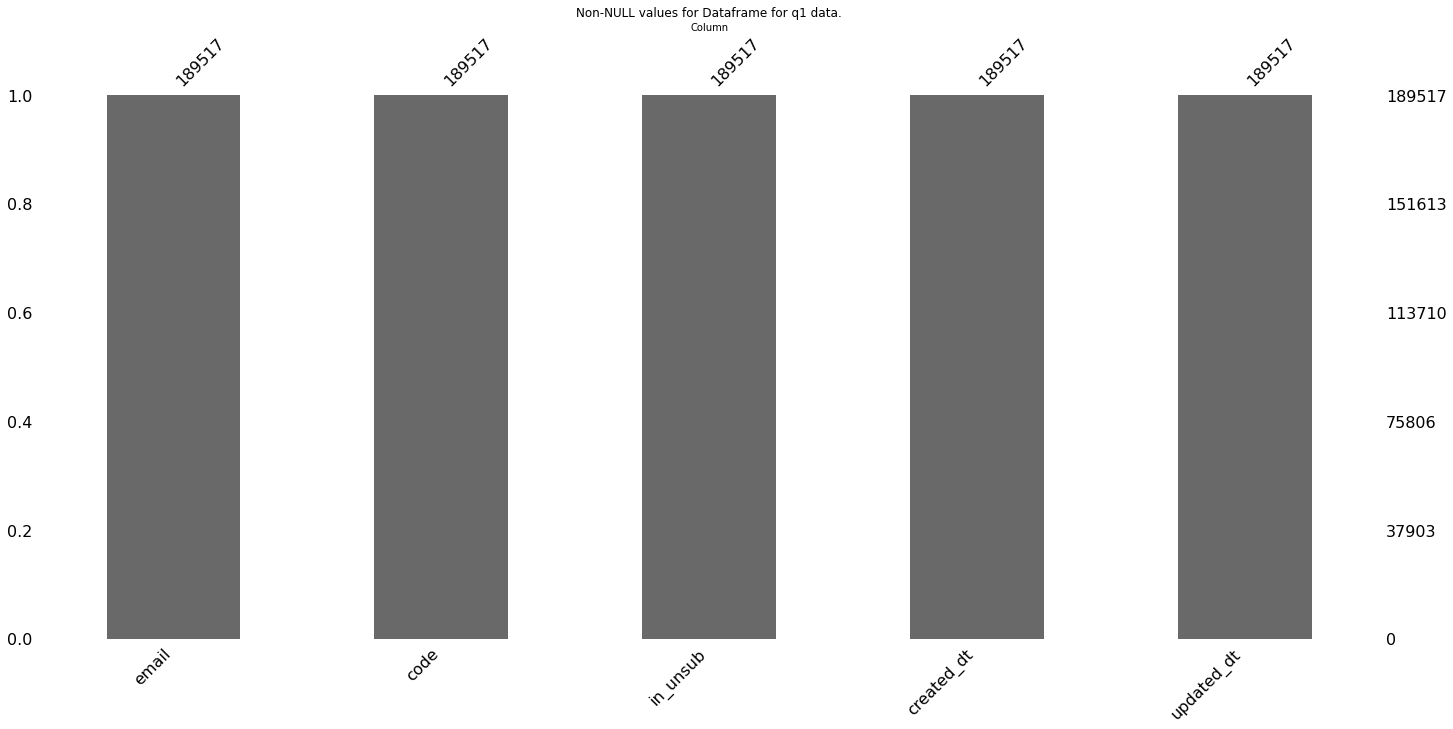

<Figure size 360x144 with 0 Axes>

In [52]:
check_df_missing_data(df_q1, "Dataframe for q1")

In [53]:
file_name = 'people.csv'

df_q1.to_csv(
    path_or_buf = file_name,
    index = False,)

print(f"Wrote dataframe to {file_name}")

Wrote dataframe to people.csv


# Q2: “Acquisition_facts” file with stats about when people where acquired

## Extract date from created_dt

In [58]:
df_q1.head()

,email,code,in_unsub,created_dt,updated_dt,acquired
0,perrymatthew@campbell.com,unknown,unknown,1979-03-01 16:12:55,2019-03-13 02:52:10,1979-03-01 16:12:55
1,gillderrick@melton.net,twitter,unknown,1987-02-17 11:22:04,2016-03-19 17:33:38,1987-02-17 11:22:04
2,tomnelson@gmail.com,google,unknown,2018-04-19 10:44:52,1993-06-25 22:34:12,2018-04-19 10:44:52
3,karenmcdaniel@hotmail.com,google,unknown,2011-03-21 17:41:32,1981-12-05 01:33:43,2011-03-21 17:41:32
4,christy72@yahoo.com,facebook,unknown,1984-03-29 19:14:34,1993-12-17 12:10:30,1984-03-29 19:14:34


In [59]:
df_q1['acquired'] = df_q1['created_dt'].dt.date

<ipython-input-59-0df073fef821>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q1['acquired'] = df_q1['created_dt'].dt.date


In [60]:
df_q1.head()

,email,code,in_unsub,created_dt,updated_dt,acquired
0,perrymatthew@campbell.com,unknown,unknown,1979-03-01 16:12:55,2019-03-13 02:52:10,1979-03-01
1,gillderrick@melton.net,twitter,unknown,1987-02-17 11:22:04,2016-03-19 17:33:38,1987-02-17
2,tomnelson@gmail.com,google,unknown,2018-04-19 10:44:52,1993-06-25 22:34:12,2018-04-19
3,karenmcdaniel@hotmail.com,google,unknown,2011-03-21 17:41:32,1981-12-05 01:33:43,2011-03-21
4,christy72@yahoo.com,facebook,unknown,1984-03-29 19:14:34,1993-12-17 12:10:30,1984-03-29


## Group values by date

In [88]:
group_var = ['acquired']

df_q2 = (
    df_q1
    .groupby( group_var, as_index = True)
    .count()
    .sort_values(group_var, ascending = True)['email']
    .reset_index()
)


df_q2.head()

,acquired,email
0,1970-01-01,9
1,1970-01-02,13
2,1970-01-03,3
3,1970-01-04,11
4,1970-01-05,12


In [89]:
print(len(df_q2))

18445


NOTE: Come back and check information. It doesn't seem likely that acquired_dates would start at UNIX Epoch Time (1970 - 01 - 01). Anne Lewis Strategies was founded in 2007. 

May like to filter data to only come after 2007.

## Write to csv

In [90]:
file_name = "acquisition_facts.csv"

df_q2.to_csv(
    path_or_buf = file_name,
    index = False
)